<a href="https://colab.research.google.com/github/Tuan-LeHoang/hira_kata_recognition/blob/main/Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%cd /content/drive/MyDrive/2023_Project/OCR

/content/drive/MyDrive/2023_Project/OCR


In [3]:
!ls

data		      hira_better_quality      __MACOSX  Train.ipynb
Data_Exploring.ipynb  hira_better_quality.zip  models


In [4]:
# !pip install japanize_matplotlib
# !pip install timm

#0. Import libs

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np # data processing
import matplotlib.pyplot as plt # Data visualization
import japanize_matplotlib
from tqdm import tqdm # Progress bar


In [6]:
import os
import pandas as pd
import torch.nn.functional as F

#1. EDA

#2. Load data

##2.1. From raw data

In [7]:
list_characters_folders = "./data/hira_better_quality/"

In [8]:
data = []
for folder in os.listdir(list_characters_folders):
    if folder == ".DS_Store":
        continue
    character_folder = os.path.join(list_characters_folders, folder)

    for character_image in os.listdir(character_folder):
        if character_image == ".DS_Store":
            continue
        character_image_path = os.path.join(character_folder, character_image)
        data.append([character_image_path, folder])

df = pd.DataFrame(data, columns=['file_name','label'])


In [9]:
df

,file_name,label
0,./data/hira_better_quality/に/5.jpg,に
1,./data/hira_better_quality/に/24.jpg,に
2,./data/hira_better_quality/に/11.jpg,に
3,./data/hira_better_quality/に/27.jpg,に
4,./data/hira_better_quality/に/1.jpg,に
...,...,...
1555,./data/hira_better_quality/か/5.jpg,か
1556,./data/hira_better_quality/か/25.jpg,か
1557,./data/hira_better_quality/か/22.jpg,か
1558,./data/hira_better_quality/か/32.jpg,か


In [10]:
sort_df = df.sort_values(by=["label"])

In [11]:
sort_df

,file_name,label
1492,./data/hira_better_quality/あ/20.jpg,あ
1494,./data/hira_better_quality/あ/22.jpg,あ
1495,./data/hira_better_quality/あ/31.jpg,あ
1496,./data/hira_better_quality/あ/32.jpg,あ
1497,./data/hira_better_quality/あ/25.jpg,あ
...,...,...
330,./data/hira_better_quality/ん/20.jpg,ん
329,./data/hira_better_quality/ん/19.jpg,ん
328,./data/hira_better_quality/ん/14.jpg,ん
334,./data/hira_better_quality/ん/32.jpg,ん


In [12]:
labels = sort_df["label"].unique()
print(labels)

['あ' 'い' 'う' 'え' 'お' 'か' 'き' 'く' 'け' 'こ' 'さ' 'し' 'す' 'せ' 'そ' 'た' 'ち' 'つ'
 'て' 'と' 'な' 'に' 'ぬ' 'ね' 'の' 'は' 'ひ' 'ふ' 'へ' 'ほ' 'ま' 'み' 'む' 'め' 'も' 'や'
 'ゆ' 'よ' 'ら' 'り' 'る' 'れ' 'ろ' 'わ' 'を' 'ん']


In [ ]:
sort_df

,file_name,label
1492,./data/hira_better_quality/あ/20.jpg,あ
1494,./data/hira_better_quality/あ/22.jpg,あ
1495,./data/hira_better_quality/あ/31.jpg,あ
1496,./data/hira_better_quality/あ/32.jpg,あ
1497,./data/hira_better_quality/あ/25.jpg,あ
...,...,...
330,./data/hira_better_quality/ん/20.jpg,ん
329,./data/hira_better_quality/ん/19.jpg,ん
328,./data/hira_better_quality/ん/14.jpg,ん
334,./data/hira_better_quality/ん/32.jpg,ん


Convert labels to one-hot vectors labels

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [ ]:
# Convert labels to numeric representation
def convert_to_one_hot_vector_labels(labels):
  label_encoder = LabelEncoder()
  numeric_labels = label_encoder.fit_transform(labels)
  # print("Numeric labels:", numeric_labels)

  # Convert numeric labels to one-hot vectors
  onehot_encoder = OneHotEncoder(sparse=False)
  onehot_labels = onehot_encoder.fit_transform(numeric_labels.reshape(-1, 1))

  return onehot_labels

In [ ]:
# a = convert_to_one_hot_vector_labels(labels)
# a.shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(46, 46)

##2.2. Split data

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(sort_df,
                                      test_size = 0.2,
                                      random_state = 42)

In [ ]:
len(train_df)

1248

In [ ]:
test_df

,file_name,label
310,./data/hira_better_quality/ん/15.jpg,ん
161,./data/hira_better_quality/ま/11.jpg,ま
70,./data/hira_better_quality/さ/10.jpg,さ
686,./data/hira_better_quality/と/23.jpg,と
986,./data/hira_better_quality/て/9.jpg,て
...,...,...
1335,./data/hira_better_quality/す/18.jpg,す
920,./data/hira_better_quality/ら/18.jpg,ら
1092,./data/hira_better_quality/い/16.jpg,い
31,./data/hira_better_quality/に/13.jpg,に


##2.3. Dataset and Dataloader

In [17]:
from types import SimpleNamespace

cfg = SimpleNamespace(**{})

In [20]:
cfg.root_dir = list_characters_folders
cfg.image_size = 224
cfg.batch_size = 32
cfg.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class CustomDataset(Dataset):
    def __init__(self,
                 cfg,
                 df,
                 transform=None,
                  mode = None):
        self.root_dir = cfg.root_dir
        self.df = df
        self.file_names = df['file_name'].values
        self.labels = convert_to_one_hot_vector_labels(df['label'].values)

        if transform and mode != "val":
          self.transform = transform
        elif mode == "train":
          self.transform = A.Compose([A.Resize(cfg.image_size, cfg.image_size),
                             A.Rotate(p=0.6, limit=[-20,20]),
                            #  A.HorizontalFlip(p = 0.6),
                             A.CoarseDropout(max_holes = 1, max_height = 32, max_width = 32, p = 0.3),
                             ToTensorV2()])
        elif mode == "val":
          self.transform = A.Compose([A.Resize(cfg.image_size, cfg.image_size),
                             ToTensorV2()])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get file_path and label for index
        label = self.labels[idx]
        file_path = self.file_names[idx]
        # file_path = os.path.join(self.root_dir, self.file_names[idx])

        # Read an image with OpenCV
        image = cv2.imread(file_path)

        # Convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Apply augmentations
        augmented = self.transform(image=image)
        image = augmented['image']

        # Normalize because ToTensorV2() doesn't normalize the image
        image = image/255

        return image, label

In [ ]:
train_dataset = CustomDataset(cfg, train_df, mode = "train")
valid_dataset = CustomDataset(cfg, test_df, mode = "val")

train_dataloader = DataLoader(train_dataset,
                          batch_size = cfg.batch_size,
                          shuffle = True)

valid_dataloader = DataLoader(valid_dataset,
                          batch_size = cfg.batch_size,
                          shuffle = False,
                              )

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#3. Model

In [ ]:
import timm

cfg.n_classes = len(labels)
cfg.backbone = 'resnet18'

model = timm.create_model(cfg.backbone,
                          pretrained = False,
                          num_classes = cfg.n_classes)

In [ ]:
model = model.to(cfg.device)

In [ ]:
X = torch.randn(cfg.batch_size, 3, cfg.image_size, cfg.image_size)
y = model(X)

In [ ]:
cfg.image_size

224

In [ ]:
y.shape

torch.Size([32, 46])

#4. Loss function, Optimizer, learning rate scheduler, measure metrics

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
cfg.learning_rate = 1e-3

optimizer = torch.optim.Adam(
  model.parameters(),
  lr = cfg.learning_rate,
  weight_decay = 0,
 )

In [ ]:
cfg.lr_min = 1e-5
cfg.epochs = 50

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
  optimizer,
  T_max = np.ceil(len(train_dataloader.dataset) / cfg.batch_size) * cfg.epochs,
  eta_min = cfg.lr_min
)

In [ ]:
from sklearn.metrics import accuracy_score

def calculate_metric(y, y_pred):
  metric = accuracy_score(y, y_pred)
  return metric

#5. Training pipeline

In [ ]:
cfg.device

device(type='cuda', index=0)

In [ ]:
def train_one_epoch(dataloader, model, optimizer, scheduler, cfg):
    # Training mode
    model.train()

    # Init lists to store y and y_pred
    final_y = []
    final_y_pred = []
    final_loss = []

    # Iterate over data
    for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = batch[0].to(cfg.device)
        y = batch[1].to(cfg.device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            # Forward: Get model outputs
            y_pred = model(X)

            # Forward: Calculate loss
            loss = criterion(y_pred, y)

            # Covert y and y_pred to lists
            final_loss.append(loss.item())

            # Backward: Optimize
            loss.backward()
            optimizer.step()

        scheduler.step()

    # Calculate statistics
    loss = np.mean(final_loss)

    return loss

In [ ]:
def validate_one_epoch(dataloader, model, cfg):
    # Validation mode
    model.eval()

    final_y = []
    final_y_pred = []
    final_loss = []

    # Iterate over data
    for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = batch[0].to(cfg.device)
        y = batch[1].to(cfg.device)

        with torch.no_grad():
            # Forward: Get model outputs
            y_pred = model(X)

            # Forward: Calculate loss
            loss = criterion(y_pred, y)

            # Covert y and y_pred to lists
            y =  y.detach().cpu().numpy().tolist()
            y_pred =  y_pred.detach().cpu().numpy().tolist()

            # Extend original list
            final_y.extend(y)
            final_y_pred.extend(y_pred)
            final_loss.append(loss.item())

    # Calculate statistics
    loss = np.mean(final_loss)
    final_y_pred = np.argmax(final_y_pred, axis=1)
    final_y_argmax = np.argmax(final_y, axis = 1)
    metric = calculate_metric(final_y_argmax, final_y_pred)

    return metric, loss

#6. Train

In [ ]:
import random

def set_seed(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

    # In general seed PyTorch operations
    torch.manual_seed(seed)

    # If you are using CUDA on 1 GPU, seed it
    torch.cuda.manual_seed(seed)

    # If you are using CUDA on more than 1 GPU, seed them all
    torch.cuda.manual_seed_all(cfg.seed)

    # Certain operations in Cudnn are not deterministic, and this line will force them to behave!
    torch.backends.cudnn.deterministic = True

    # Disable the inbuilt cudnn auto-tuner that finds the best algorithm to use for your hardware.
    torch.backends.cudnn.benchmark = False

In [ ]:
cfg.seed = 42

def fit(model, optimizer, scheduler, cfg, train_dataloader, valid_dataloader=None):
    loss_list = []
    val_acc_list = []
    val_loss_list = []

    for epoch in range(cfg.epochs):
        print(f"Epoch {epoch + 1}/{cfg.epochs}")

        set_seed(cfg.seed + epoch)

        loss = train_one_epoch(train_dataloader, model, optimizer, scheduler, cfg)

        if valid_dataloader:
            val_acc, val_loss = validate_one_epoch(valid_dataloader, model, cfg)

        print(f'Loss: {loss:.4f}')
        loss_list.append(loss)

        if valid_dataloader:
            print(f'Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')
            val_acc_list.append(val_acc)
            val_loss_list.append(val_loss)

    return loss_list, val_acc_list, val_loss_list

In [ ]:
loss, val_acc, val_loss = fit(model, optimizer, scheduler, cfg, train_dataloader, valid_dataloader)

Epoch 1/50


100%|██████████| 10/10 [00:00<00:00, 10.32it/s]


Loss: 0.0690
Val Loss: 0.2158 Val Acc: 0.9455
Epoch 2/50


100%|██████████| 10/10 [00:01<00:00,  9.98it/s]


Loss: 0.0669
Val Loss: 0.2298 Val Acc: 0.9423
Epoch 3/50


100%|██████████| 10/10 [00:01<00:00,  9.67it/s]


Loss: 0.0390
Val Loss: 0.2041 Val Acc: 0.9487
Epoch 4/50


100%|██████████| 10/10 [00:01<00:00,  9.83it/s]


Loss: 0.0430
Val Loss: 0.2143 Val Acc: 0.9583
Epoch 5/50


100%|██████████| 10/10 [00:01<00:00,  9.15it/s]


Loss: 0.0334
Val Loss: 0.2033 Val Acc: 0.9583
Epoch 6/50


100%|██████████| 10/10 [00:01<00:00,  9.60it/s]


Loss: 0.0284
Val Loss: 16.3679 Val Acc: 0.2019
Epoch 7/50


100%|██████████| 10/10 [00:01<00:00,  9.10it/s]


Loss: 0.0199
Val Loss: 0.1830 Val Acc: 0.9712
Epoch 8/50


100%|██████████| 10/10 [00:01<00:00,  9.39it/s]


Loss: 0.0193
Val Loss: 0.2094 Val Acc: 0.9583
Epoch 9/50


100%|██████████| 10/10 [00:01<00:00,  9.17it/s]


Loss: 0.0237
Val Loss: 0.2015 Val Acc: 0.9679
Epoch 10/50


100%|██████████| 10/10 [00:01<00:00,  9.30it/s]


Loss: 0.0212
Val Loss: 0.2041 Val Acc: 0.9647
Epoch 11/50


100%|██████████| 10/10 [00:01<00:00,  9.01it/s]


Loss: 0.0163
Val Loss: 0.1925 Val Acc: 0.9712
Epoch 12/50


100%|██████████| 10/10 [00:01<00:00,  9.93it/s]


Loss: 0.0197
Val Loss: 0.1756 Val Acc: 0.9776
Epoch 13/50


100%|██████████| 10/10 [00:01<00:00,  9.78it/s]


Loss: 0.0132
Val Loss: 0.2111 Val Acc: 0.9583
Epoch 14/50


100%|██████████| 10/10 [00:01<00:00,  9.81it/s]


Loss: 0.0141
Val Loss: 0.1758 Val Acc: 0.9712
Epoch 15/50


100%|██████████| 10/10 [00:01<00:00,  9.90it/s]


Loss: 0.0145
Val Loss: 0.2165 Val Acc: 0.9583
Epoch 16/50


100%|██████████| 10/10 [00:01<00:00,  9.71it/s]


Loss: 0.0097
Val Loss: 0.1882 Val Acc: 0.9679
Epoch 17/50


100%|██████████| 10/10 [00:01<00:00,  9.84it/s]


Loss: 0.0103
Val Loss: 0.1930 Val Acc: 0.9647
Epoch 18/50


100%|██████████| 10/10 [00:01<00:00,  9.79it/s]


Loss: 0.0237
Val Loss: 0.1807 Val Acc: 0.9776
Epoch 19/50


100%|██████████| 10/10 [00:01<00:00,  9.74it/s]


Loss: 0.0200
Val Loss: 0.1862 Val Acc: 0.9712
Epoch 20/50


100%|██████████| 10/10 [00:01<00:00,  8.87it/s]


Loss: 0.0325
Val Loss: 0.1902 Val Acc: 0.9647
Epoch 21/50


100%|██████████| 10/10 [00:01<00:00,  9.46it/s]


Loss: 0.0269
Val Loss: 0.1912 Val Acc: 0.9712
Epoch 22/50


100%|██████████| 10/10 [00:01<00:00,  8.98it/s]


Loss: 0.0181
Val Loss: 0.1756 Val Acc: 0.9679
Epoch 23/50


100%|██████████| 10/10 [00:01<00:00,  9.96it/s]


Loss: 0.0186
Val Loss: 0.2132 Val Acc: 0.9615
Epoch 24/50


100%|██████████| 10/10 [00:01<00:00,  9.25it/s]


Loss: 0.0216
Val Loss: 0.1954 Val Acc: 0.9679
Epoch 25/50


100%|██████████| 10/10 [00:01<00:00,  9.65it/s]


Loss: 0.0158
Val Loss: 0.1878 Val Acc: 0.9615
Epoch 26/50


100%|██████████| 10/10 [00:01<00:00,  9.16it/s]


Loss: 0.0194
Val Loss: 0.1832 Val Acc: 0.9615
Epoch 27/50


100%|██████████| 10/10 [00:01<00:00,  9.81it/s]


Loss: 0.0165
Val Loss: 0.1740 Val Acc: 0.9647
Epoch 28/50


100%|██████████| 10/10 [00:01<00:00,  9.77it/s]


Loss: 0.0189
Val Loss: 0.1815 Val Acc: 0.9615
Epoch 29/50


100%|██████████| 10/10 [00:01<00:00,  9.83it/s]


Loss: 0.0118
Val Loss: 0.1820 Val Acc: 0.9615
Epoch 30/50


100%|██████████| 10/10 [00:01<00:00,  9.81it/s]


Loss: 0.0183
Val Loss: 0.1837 Val Acc: 0.9615
Epoch 31/50


100%|██████████| 10/10 [00:01<00:00,  9.67it/s]


Loss: 0.0112
Val Loss: 0.1802 Val Acc: 0.9647
Epoch 32/50


100%|██████████| 10/10 [00:00<00:00, 10.13it/s]


Loss: 0.0105
Val Loss: 0.1842 Val Acc: 0.9647
Epoch 33/50


100%|██████████| 10/10 [00:01<00:00,  9.15it/s]


Loss: 0.0166
Val Loss: 0.1849 Val Acc: 0.9679
Epoch 34/50


100%|██████████| 10/10 [00:01<00:00,  9.76it/s]


Loss: 0.0089
Val Loss: 0.1819 Val Acc: 0.9647
Epoch 35/50


100%|██████████| 10/10 [00:01<00:00,  9.07it/s]


Loss: 0.0134
Val Loss: 0.1933 Val Acc: 0.9647
Epoch 36/50


100%|██████████| 10/10 [00:01<00:00,  9.67it/s]


Loss: 0.0115
Val Loss: 0.1859 Val Acc: 0.9647
Epoch 37/50


100%|██████████| 10/10 [00:01<00:00,  9.14it/s]


Loss: 0.0137
Val Loss: 0.1829 Val Acc: 0.9615
Epoch 38/50


100%|██████████| 10/10 [00:01<00:00,  9.84it/s]


Loss: 0.0092
Val Loss: 0.1874 Val Acc: 0.9647
Epoch 39/50


100%|██████████| 10/10 [00:01<00:00,  9.34it/s]


Loss: 0.0161
Val Loss: 0.1877 Val Acc: 0.9679
Epoch 40/50


100%|██████████| 10/10 [00:01<00:00,  9.75it/s]


Loss: 0.0114
Val Loss: 0.1811 Val Acc: 0.9712
Epoch 41/50


100%|██████████| 10/10 [00:01<00:00,  9.69it/s]


Loss: 0.0131
Val Loss: 0.1830 Val Acc: 0.9679
Epoch 42/50


100%|██████████| 10/10 [00:01<00:00,  9.32it/s]


Loss: 0.0102
Val Loss: 0.1814 Val Acc: 0.9647
Epoch 43/50


100%|██████████| 10/10 [00:01<00:00,  9.70it/s]


Loss: 0.0153
Val Loss: 0.1823 Val Acc: 0.9647
Epoch 44/50


100%|██████████| 10/10 [00:01<00:00,  9.83it/s]


Loss: 0.0093
Val Loss: 0.1829 Val Acc: 0.9647
Epoch 45/50


100%|██████████| 10/10 [00:01<00:00,  9.85it/s]


Loss: 0.0130
Val Loss: 0.1907 Val Acc: 0.9647
Epoch 46/50


100%|██████████| 10/10 [00:01<00:00,  9.72it/s]


Loss: 0.0134
Val Loss: 0.1804 Val Acc: 0.9712
Epoch 47/50


100%|██████████| 10/10 [00:01<00:00,  9.87it/s]


Loss: 0.0089
Val Loss: 0.1823 Val Acc: 0.9615
Epoch 48/50


100%|██████████| 10/10 [00:01<00:00,  8.82it/s]


Loss: 0.0128
Val Loss: 0.1809 Val Acc: 0.9679
Epoch 49/50


100%|██████████| 10/10 [00:01<00:00,  9.63it/s]


Loss: 0.0168
Val Loss: 0.1826 Val Acc: 0.9647
Epoch 50/50


100%|██████████| 10/10 [00:01<00:00,  9.15it/s]


Loss: 0.0121
Val Loss: 0.1803 Val Acc: 0.9647


#6. Visualize loss, acc

In [ ]:
def visualize_history(loss, val_acc, val_loss):
    fig, ax = plt.subplots(1,2, figsize=(12,4))

    ax[0].plot(range(len(loss)), loss,  color='darkgrey', label = 'train')
    ax[0].plot(range(len(val_loss)), val_loss,  color='cornflowerblue', label = 'valid')
    ax[0].set_title('Loss')

    # ax[1].plot(range(len(acc)), acc,  color='darkgrey', label = 'train')
    ax[1].plot(range(len(val_acc)), val_acc,  color='cornflowerblue', label = 'valid')
    ax[1].set_title('Metric (Accuracy)')

    for i in range(2):
        ax[i].set_xlabel('Epochs')
        ax[i].legend(loc="upper right")
    plt.show()

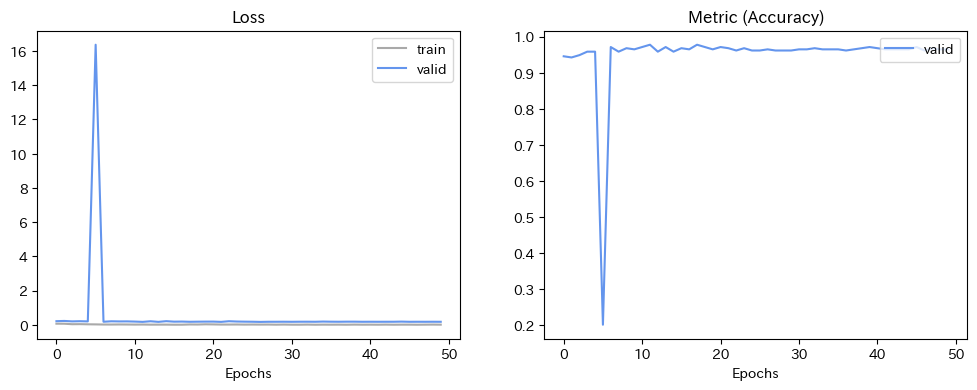

In [ ]:
visualize_history(loss, val_acc, val_loss)

#7. Save model

In [ ]:
# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# # Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

In [ ]:
#Save state dict
saved_model_path = "./models/1/state_dict.pt"
torch.save(model.state_dict(), saved_model_path)

In [ ]:
saved_model_path = "./models/1/model.pt"
torch.save(model, saved_model_path)

#8. Explore model

In [13]:
model_path_for_exploring = "./models/1/model.pt"
model_x = torch.load(model_path_for_exploring)


In [21]:
model_x = model_x.to(cfg.device)

In [ ]:
# get some random training images
dataiter = iter(valid_dataloader)
images, labels = next(dataiter)

In [ ]:
images.shape

torch.Size([32, 3, 224, 224])

In [ ]:
labels

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [ ]:
len(images)

32

In [ ]:
X = images.to(cfg.device)
y = labels.to(cfg.device)

with torch.no_grad():
    # Forward: Get model outputs
    y_pred = model_x(X)

    # Forward: Calculate loss
    loss = criterion(y_pred, y)

    # Covert y and y_pred to lists
    y =  y.detach().cpu().numpy().tolist()
    y_pred =  y_pred.detach().cpu().numpy().tolist()

    # Extend original list
    final_y_pred_argmax = np.argmax(y_pred, axis=1)
    final_y_argmax = np.argmax(y, axis = 1)
    metric_test = calculate_metric(final_y_argmax, final_y_pred_argmax)

In [ ]:
metric_test

1.0

In [ ]:
final_y_pred_argmax

array([45, 30, 10, 19, 18,  7,  1, 17,  6, 14,  0, 10, 40, 45, 24,  8, 14,
       30, 44, 15, 41,  5,  6, 19, 40, 11, 30,  8, 37, 31, 32,  3])

In [ ]:
final_y_argmax

array([45, 30, 10, 19, 18,  7,  1, 17,  6, 14,  0, 10, 40, 45, 24,  8, 14,
       30, 44, 15, 41,  5,  6, 19, 40, 11, 30,  8, 37, 31, 32,  3])

In [ ]:
test_df

,file_name,label
310,./data/hira_better_quality/ん/15.jpg,ん
161,./data/hira_better_quality/ま/11.jpg,ま
70,./data/hira_better_quality/さ/10.jpg,さ
686,./data/hira_better_quality/と/23.jpg,と
986,./data/hira_better_quality/て/9.jpg,て
...,...,...
1335,./data/hira_better_quality/す/18.jpg,す
920,./data/hira_better_quality/ら/18.jpg,ら
1092,./data/hira_better_quality/い/16.jpg,い
31,./data/hira_better_quality/に/13.jpg,に


In [22]:
def inference_for_an_image(image_path = None, model_x = None):
  image = cv2.imread(image_path)

  # Convert the image to RGB color space.
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # Apply augmentations
  transform = A.Compose([A.Resize(cfg.image_size, cfg.image_size),
                              ToTensorV2()])
  augmented = transform(image=image)
  image = augmented['image']

  image = image/255
  image = image.to(cfg.device)

  image_tensor_batch1 = image.unsqueeze(0)

  predict = model_x(image_tensor_batch1)
  y_pred1 =  predict.detach().cpu().numpy()
  character_label = labels[np.argmax(y_pred1)]

  return character_label

In [23]:
sort_df["predicted_labels"] = sort_df["file_name"].apply(lambda x : inference_for_an_image(str(x), model_x))

In [24]:
comparison = sort_df["label"] == sort_df["predicted_labels"]
sort_df["Correct"] = comparison

In [26]:
len(sort_df)

1560

In [25]:
sort_df["Correct"].sum()

1549

In [28]:
sort_df2 = sort_df[sort_df["Correct"] == False]

In [29]:
sort_df2

,file_name,label,predicted_labels,Correct
1508,./data/hira_better_quality/あ/28.jpg,あ,よ,False
716,./data/hira_better_quality/そ/16.jpg,そ,を,False
964,./data/hira_better_quality/つ/1.jpg,つ,ち,False
577,./data/hira_better_quality/ね/26.jpg,ね,れ,False
1155,./data/hira_better_quality/は/14.jpg,は,ほ,False
1159,./data/hira_better_quality/は/19.jpg,は,ほ,False
1192,./data/hira_better_quality/も/21.jpg,も,よ,False
112,./data/hira_better_quality/ゆ/24.jpg,ゆ,ぬ,False
123,./data/hira_better_quality/ゆ/25.jpg,ゆ,め,False
1382,./data/hira_better_quality/り/1.jpg,り,て,False


In [ ]:
image_path = "./data/hira_better_quality/ん/15.jpg"
a = inference_for_an_image(image_path = image_path, model_x = model_x)
print(a)

./data/hira_better_quality/ん/15.jpg
torch.Size([1, 3, 224, 224])
ん


In [ ]:
test_df["predicted_labels"] = df["file_name"].apply(lambda x : inference_for_an_image(str(x), model_x))

In [ ]:
comparison = test_df["label"] == test_df["predicted_labels"]

In [ ]:
test_df["Correct"] = comparison

In [ ]:
len(test_df)

312

In [ ]:
test_df["Correct"].sum()

301

In [ ]:
301/312

0.9647435897435898

In [ ]:
test_df2 =  test_df[test_df["Correct"] == False]

In [1]:
test_df2

NameError: ignored

##8.2. Save explored results

In [30]:
explored_saved_results_path = "./models/1/explore_model/all_data_results.xlsx"

In [31]:
sort_df.to_excel(explored_saved_results_path, index = False)

#9. References
+ https://towardsdatascience.com/pytorch-image-classification-tutorial-for-beginners-94ea13f56f2